<a href="https://colab.research.google.com/github/MarlaS02/comp215/blob/Practice/labs/lab08_GoL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name:
#### Date:

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [ ]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [ ]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

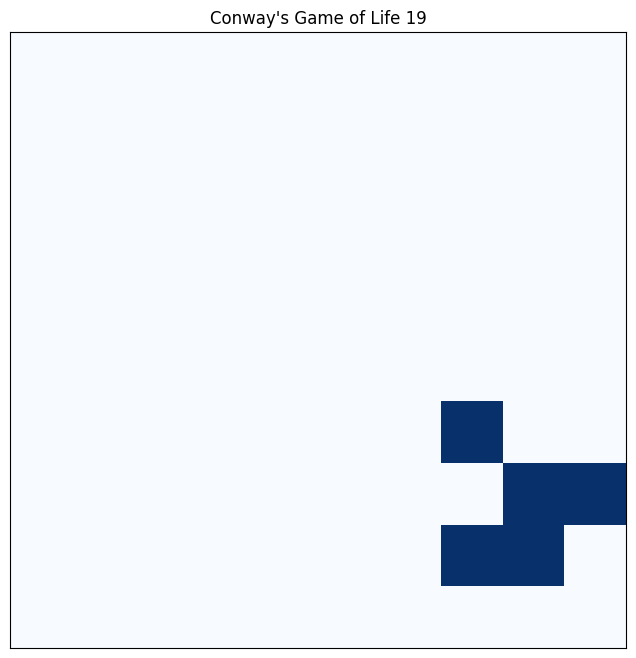

In [ ]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

In [ ]:
# Ex. 1 your code here...
number_of_states = 2**9
number_of_rules = 2**(number_of_states)
number_of_atoms_universe = 10**80

print(f'There are {number_of_states} unique states for a 3x3 neighbourhood.')
print(f'There are {number_of_rules} unique rules for a 3x3 neighbourhood.')
print(f'There are {number_of_atoms_universe} observable atoms in the universe')
print(f'This number compares to the number of atoms in the observable universe with a ratio of {number_of_rules/number_of_atoms_universe}. The ratio shows just how large the number of possible rules is - there are more possible rules for a 3x3 neighborhood than atoms in the observable universe!')




There are 512 unique states for a 3x3 neighbourhood.
There are 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096 unique rules for a 3x3 neighbourhood.
There are 100000000000000000000000000000000000000000000000000000000000000000000000000000000 observable atoms in the universe
This number compares to the number of atoms in the observable universe with a ratio of 1.3407807929942597e+74. The ratio shows just how large the number of possible rules is - there are more possible rules for a 3x3 neighborhood than atoms in the observable universe!


Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1. Wolframs experiment yielded rules from 0-255, the same experiment for 2D CA would give us a number of rules so large I don't even want to type it out, which means while it would definitely be interesting to conduct this research, it seems very complex and time consuming and I am not sure if we have the resources to do so yet.
2. Maybe you could treat it dependend on each row and use Wolframs rules for that, so for example if the top row of the 3x3 grid corresponds to Wolframs 19th rule, the middle one to the 76th rule and the bottom one to the 145th rule the 2D CA would have number 19-76-145.
Or, if you wanted a single number, you could just go with rule 0 to rule 2^(512)-1, which I think would be very inconvenient.
Alternatively, I guess you could express the rules in binary, just like wolfram did, only that we would have 512 bit instead of 8, which still doesn't seem super easy to work with to me, but might be the clearest way of classifying them.
3. You would have to iterate through each cell and update its state (either 0 or 1) to a list or something, so that you end up with a binary number

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

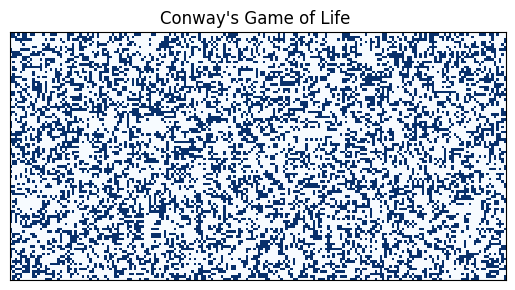

In [18]:
# Ex. 2 experimental setup
#Extend the Life2D class defined above to allow the game to be initialized with a random start state. The liklihood of any given cell being initialized to "alive" is given by  p .
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, p,n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        self.p = p
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        #The following line was modified to initialize the state variable to be a 2D array with random values of 0 or 1 based on the probability p.
        self.state = np.random.choice([0, 1], size=(n_rows, n_cols), p=[1 - p, p])
    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

life = Life2D(100, 0.4, 200)
life.step()
life.draw()

### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

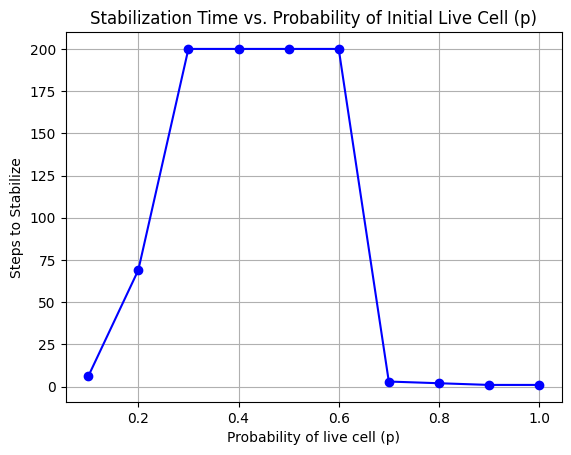

In [ ]:
# Ex. 2 write code for your experiment here...
def run_experiment(n_rows=20, n_cols=20, max_steps=200):

    p_values = np.linspace(0.1, 1.0, 10)
    stabilization_times = []

    for p in p_values:
        life_game = random_life(n_rows, n_cols, p)
        prev_state = None
        for step in range(max_steps):
            life_game.step()
            if np.array_equal(life_game.state, prev_state):
                stabilization_times.append(step)
                break
            prev_state = life_game.state
        else:
            stabilization_times.append(max_steps)

    return p_values, stabilization_times


p_values, stabilization_times = run_experiment()


plt.plot(p_values, stabilization_times, marker='o', linestyle='-', color='b')
plt.xlabel("Probability of live cell (p)")
plt.ylabel("Steps to Stabilize")
plt.title("Stabilization Time vs. Probability of Initial Live Cell (p)")
plt.grid(True)
plt.show()

#I ran the algorithm multiple times and the graph looks different each time - sometimes smaller values of p require less steps before stabilizing, sometimes they require a lot more steps than the larger values of p, so I would conclude that the two aren't related

## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [ ]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Ex. 3 your code here...

def string_to_2D_array(pattern_string):
    lines = pattern_string.strip().split('\n')
    rows = []
    for line in lines:
        row = [int(char) for char in line.strip()]
        rows.append(row)
    return np.array(rows)

print(string_to_2D_array(glider_pattern))

[[0 1 0]
 [0 0 1]
 [1 1 1]]


### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

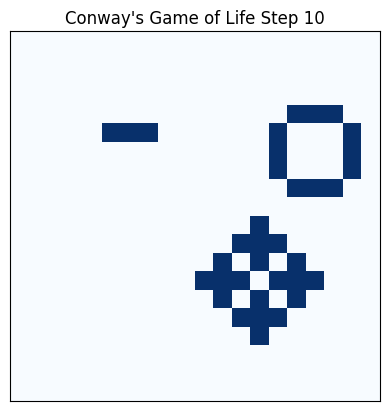

In [ ]:
# Ex. 3 define your patterns here...

#Got the examples from chatgbt (asked for interesing patterns to code in 2D array with python)

blinker_str = '''
111
'''
blinker_pattern = string_to_2D_array(blinker_str)

glider_str = '''
00100
01000
01110
00010
00010
'''
glider_pattern = string_to_2D_array(glider_str)

toad_str = '''
01110
11100
01110
'''
toad_pattern = string_to_2D_array(toad_str)

gol = BetterLife2D(20, 20)

gol.load_pattern(5, 5, blinker_pattern)
gol.load_pattern(10, 10, glider_pattern)
gol.load_pattern(15, 5, toad_pattern)

gol.draw(step='Initial State')


for step in range(10):
    gol.step()
    gol.draw(step=f'Step {step + 1}')

### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

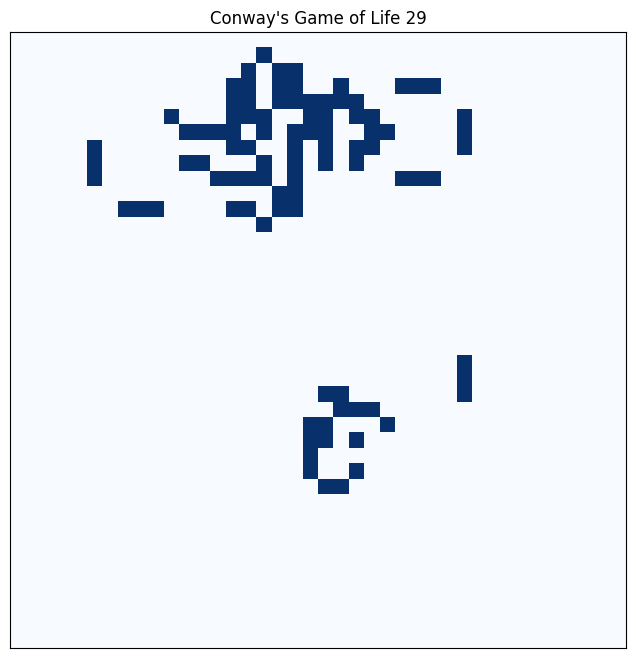

In [ ]:
# Ex. 3 code for your experiment here

glider_gun_str = '''
00000000000000000000
00000000000000010010
00000000000000111110
00000000000001000000
00000000010000000000
00000000010000010000
00000000000000000000
00000000010000000000
00000000010000000000
00000000000000000000
00000000000000000000
'''
glider_gun_pattern = string_to_2D_array(glider_gun_str)

block_str = '''
111
101
111
'''
block_pattern = string_to_2D_array(block_str)

gol = BetterLife2D(40, 40)

gol.load_pattern(5, 5, glider_pattern)
gol.load_pattern(15, 5, toad_pattern)
gol.load_pattern(25, 5, block_pattern)
gol.load_pattern(10, 20, glider_gun_pattern)

gol.draw(step='Initial State')

Animation2D(gol, frames = 30).animate()
